In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Conv1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
# ----- 1. Set Seeds for Reproducibility -----
seed_value = 150
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

# ----- 2. Load Data and Preprocess -----
df = pd.read_csv('deep_learning_preprocessed.csv')
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

# Manually normalize weekday (range 0-6 scaled to 0-1)
df['weekday_norm'] = df['weekday_num'] / 6.0

# Use a dedicated scaler for cups_sold (target)
scaler_y = MinMaxScaler(feature_range=(0, 1))
cups_sold_scaled = scaler_y.fit_transform(df[['cups_sold']])

# Combine features: use scaled cups_sold and the normalized weekday
# (The weekday is already between 0 and 1.)
X = np.concatenate([cups_sold_scaled, df[['weekday_norm']].values], axis=1)
y = cups_sold_scaled  # Target is cups_sold scaled

In [3]:
# ----- 3. Create Time-Series Dataset (Sliding Window) -----
def create_dataset(X, y, window_size):
    X_data, y_data = [], []
    for i in range(len(X) - window_size):
        X_data.append(X[i:i + window_size])
        y_data.append(y[i + window_size])
    return np.array(X_data), np.array(y_data)

window_size = 7  # Number of days to look back
X_data, y_data = create_dataset(X, y, window_size)


In [4]:
# ----- 4. Split the Data: Training (80%), Validation (10%), Test (10%) -----
train_size = int(len(X_data) * 0.8)
val_size = int(len(X_data) * 0.1)

X_train = X_data[:train_size]
y_train = y_data[:train_size]

X_val = X_data[train_size:train_size + val_size]
y_val = y_data[train_size:train_size + val_size]

X_test = X_data[train_size + val_size:]
y_test = y_data[train_size + val_size:]


In [5]:
# ----- 5. Build the CNN-LSTM Model -----
model = Sequential([
    # First LSTM layer with return_sequences for subsequent layers
    LSTM(128, activation='relu', return_sequences=True, input_shape=(window_size, X_train.shape[2])),
    BatchNormalization(),
    Dropout(0.3),
    
    # Convolution layer to extract local features from the sequence
    Conv1D(filters=128, kernel_size=3, activation='relu', padding='causal'),
    BatchNormalization(),
    Dropout(0.2),
    
    # Second LSTM layer (without return_sequences)
    LSTM(128, activation='relu'),
    Dropout(0.1),
    
    # Output layer
    Dense(1)
])
optimizer = Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss='mse')

C:\Users\USER\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [6]:
# ----- 6. Callbacks for Training -----
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)


In [7]:
# ----- 7. Train the Model -----
history = model.fit(X_train, y_train, epochs=100, batch_size=16,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stop, reduce_lr],
                    verbose=1)

Epoch 1/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - loss: 0.2150 - val_loss: 0.0998 - learning_rate: 5.0000e-04
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0911 - val_loss: 0.0953 - learning_rate: 5.0000e-04
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0574 - val_loss: 0.0907 - learning_rate: 5.0000e-04
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0495 - val_loss: 0.0882 - learning_rate: 5.0000e-04
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0449 - val_loss: 0.0812 - learning_rate: 5.0000e-04
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0356 - val_loss: 0.0791 - learning_rate: 5.0000e-04
Epoch 7/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0428 - val_loss: 0.0691 - learning_rate: 5.0000e-04
Epoch 8/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0385 - val_loss: 0.0786 - learning_rate: 5.0000e-04
Epoch 9/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0367 - val_loss: 0.0684 - 

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 382ms/step


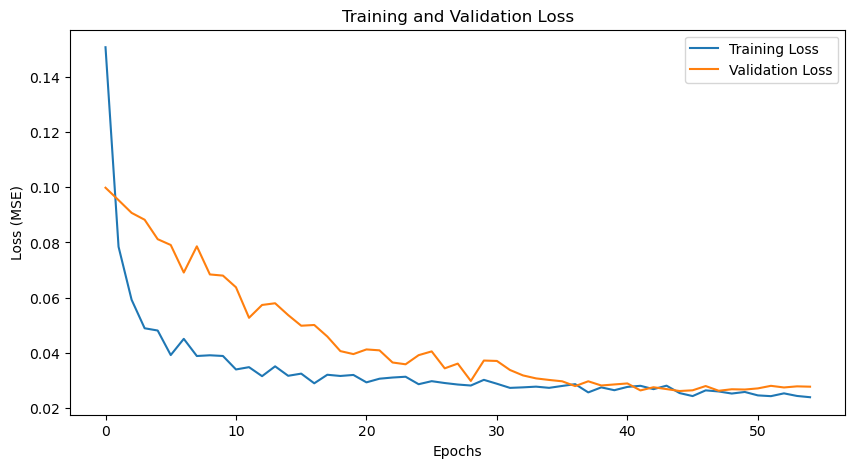

In [8]:
# ----- 8. Evaluate on the Test Set -----
y_pred_scaled = model.predict(X_test)
# Inverse-transform predictions back to original cups_sold scale
y_pred = scaler_y.inverse_transform(y_pred_scaled)

# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [9]:
# ----- 9. Recursive Forecasting Function for Future Predictions -----
def forecast_future(model, last_window, future_weekdays, scaler_y):
    """
    Recursively forecast future cups_sold.
    
    Parameters:
      model: Trained CNN-LSTM model.
      last_window: The last observed window (shape: window_size x features).
      future_weekdays: Iterable of future weekday numbers.
      scaler_y: Scaler used for inverse transforming cups_sold.
      
    Returns:
      Array of forecasted cups_sold (in original scale).
    """
    predictions = []
    current_window = last_window.copy()  # Shape: (window_size, 2)
    for wd in future_weekdays:
        pred_scaled = model.predict(current_window[np.newaxis, :, :])
        predictions.append(pred_scaled[0, 0])
        # Prepare new row: predicted cups_sold (scaled) and normalized weekday
        new_row = np.array([pred_scaled[0, 0], wd / 6.0])
        # Slide the window by dropping the oldest and appending the new row
        current_window = np.vstack([current_window[1:], new_row])
    # Inverse transform predictions to original scale
    predictions = scaler_y.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()
    return predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


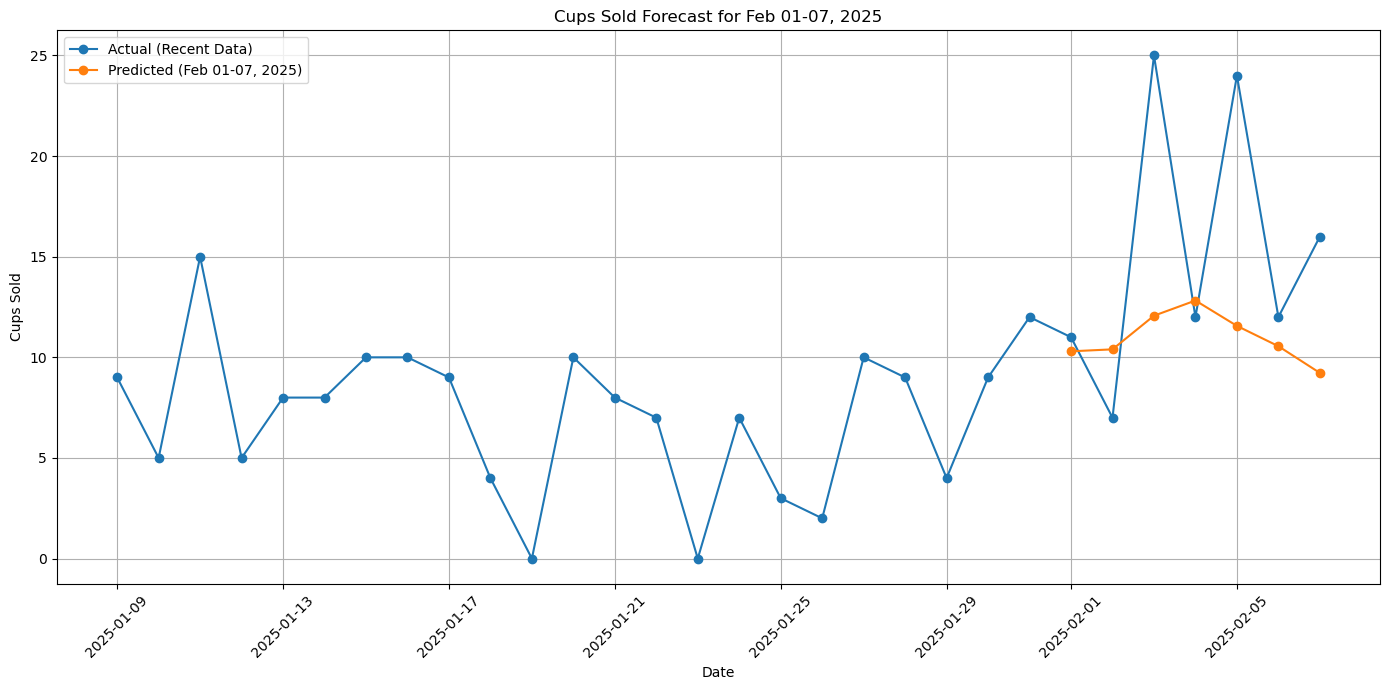

In [10]:
# ----- 10. Forecast Future 7 Days (Feb 01–07, 2025) -----
future_dates = pd.date_range(start='2025-02-01', periods=7, freq='D')
future_weekdays = future_dates.weekday  # Monday=0, Tuesday=1, etc.

# Use the last available window from the dataset as the starting point
last_window = X_data[-1]  # Shape: (window_size, 2)

future_preds = forecast_future(model, last_window, future_weekdays, scaler_y)

# Plot recent actual cups_sold and the future predictions
plt.figure(figsize=(14, 7))
plt.plot(df['cups_sold'][-30:], label='Actual (Recent Data)', marker='o')
plt.plot(future_dates, future_preds, label='Predicted (Feb 01-07, 2025)', marker='o')
plt.xlabel('Date')
plt.ylabel('Cups Sold')
plt.title('Cups Sold Forecast for Feb 01-07, 2025')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [11]:
# ----- 11. Calculate Error Metrics for Future Predictions -----
# Replace these with the actual observed cups_sold for Feb 01–07, 2025 as available.
actual_7_days = np.array([11, 7, 25, 12, 24, 12, 26])

mae = mean_absolute_error(actual_7_days, future_preds)
rmse = np.sqrt(mean_squared_error(actual_7_days, future_preds))
mape = np.mean(np.abs((actual_7_days - future_preds) / actual_7_days)) * 100

print("Mean Absolute Error (MAE):", mae)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Percentage Error (MAPE):", mape)

Mean Absolute Error (MAE): 6.929936000279018
Root Mean Squared Error (RMSE): 9.39677098563095
Mean Absolute Percentage Error (MAPE): 34.552376682437014
